<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2022/blob/main/notebooks/es3/MetodiAI_Fis2022_Es3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esercitazione 3: uso libreria pandas, classificazione e regressione con algoritmi Naive-Bayes e k-NN

**Task:** implementare algoritmi di classificazione e regressione basati su stima delle densità di probabilità (Naive-Bayes e k-NN) per l'identificazione di sub-strutture in Jetti adronici in eventi prodotti a LHC

Referenza: [https://arxiv.org/abs/1603.09349](https://arxiv.org/abs/1603.09349)https://arxiv.org/abs/1603.09349

**Operazioni preliminari: download del dataset ...**

NOTA: dataset esteso, 231MB compresso, tipicamente richiede un 2-5 minuti per essere scaricato

In [49]:
!rm -rf JetSubStruct.dat
!rm -rf JetSubStruct.dat.gz
!wget http://giagu.web.cern.ch/giagu/CERN/JetSubStruct.dat.gz
!gunzip JetSubStruct.dat.gz

--2022-03-18 15:26:55--  http://giagu.web.cern.ch/giagu/CERN/JetSubStruct.dat.gz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242587110 (231M) [application/gzip]
Saving to: ‘JetSubStruct.dat.gz’

JetSubStruct.dat.gz 100%[===================>] 231.35M  1.80MB/s    in 4m 29s  

2022-03-18 15:31:24 (881 KB/s) - ‘JetSubStruct.dat.gz’ saved [242587110/242587110]



**Parte 1:**

Importazione del dataset in un dataframe pandas e analisi statistica e visuale del dataset stesso.

Il dataset è costituito da 10M (è bene leggerne solo una parte (10k eventi per non rendere troppo lento addestrare modelli (specialemente k-NN)) di eventi appartenenti a due processi fisici prodotti nelle interazioni protone-protone a LHC: 
QCD di-jet production $q\bar{q} \to jet\,jet$ (fondo), e EW boosted $W$ 

* QCD di-jet production $q\bar{q} \to jet\,jet$ (fondo)
* EW boosted $W$ decays in di-jet $W \to  \to qq' \to jet\,jet$ (segnale)

Gli stati finali visibili nel rivelatore (getti adronici ($jet$)) sono molto simili nei due processi, ma nel caso dei decadimenti del $W$ a causa dell'alto boost di lorentz i due jet tendono a sovrapporsi crendo un singolo jet detto "merged". La presenza dei due jet sovrapposti crea delle sotto-strutture peculiari all'interno del deposito di energia del jet che possono essere utilizzate per discriminare i "merged" jet dai jet di QCD.

Ogni evnto del dataset rappresenta un jet, descritto da 6 osservabili fisiche di alto livello (feature) e da una label $1,0$ che indica se l'evento è di classe segnale o di classe fondo.

Le osservabili di alto livello sono:

*   $Mjet$: massa invariante del Jet
*   $C21, C21, D21, D22$: 4 funzioni di correlazione energetiche tra i sotto-elementi del jet
*   $Tau21$: 21-subjetiness (una misura di quanto il jet è composto da 2 vs 1-subjet), tende a $1$ per jet composti da un solo jet e a 0 per jet formati da due jet 

I dati sono contenuti nel file *JetSubStruct.dat*, che è un file *.csv* in cui ogni riga contiene le 6 osservabili + la label del campione.

**compiti:**
1.   importare il file in un dataframe pandas

```
df = pd.read_csv(nomefile, nrows=10000)
```

2.   ottenere la statistica descrittiva del dataset: valori medi, varianze, e matrice di correlazione per le 6 osservabili (non utilizzate la label come variabile). Per farlo sfruttare i metodi di pandas applicabili ad un dataframe df: *df.describe()* e *df.corr()*
3.   graficare gli istogrammi delle 6 osservabili con in rosso gi eventi della classe segnale (W) e in blu gli eventi della classe fondo (QCD)


```
# si può selezionare una variabile (colonna) specifica del dataframe con:
colonne = list(df.columns)
print(colonne)

df['C21'] #seleziona la colonna cintenete la feature C21

# si possono selezionare righe applicando condizioni sulle colonne
# esempio: seleziono solo gli eventi con Label = 1 (segnale):

dfS = df.loc[df['Label']>0.5] #dfS è un nuovo dataset contenenete solo le righe in cui il valore della Label è maggiore di 0.5

```


4.   graficare i plot di correlazione tra le coppie di osservabili per le due classi

```
#suggerimento: usare la funzione pandas *scatter_matrix* 
from pandas.plotting import scatter_matrix
```


In [47]:
#codice

colonne presenti nel pand dataframe:
['Mjet', 'C21', 'C22', 'D21', 'D22', 'Tau12', 'Label']

Contenuto del dataframe pandas


,Mjet,C21,C22,D21,D22,Tau12,Label
0,83.1238,0.056322,0.007502,0.431626,0.122363,0.083797,1.0
1,114.0480,0.092756,0.016106,0.705808,0.146008,0.126179,0.0
2,40.1448,0.069905,0.009982,0.999098,0.572507,0.312938,0.0
3,21.6843,0.074390,0.019001,2.117070,3.688260,0.442132,0.0
4,17.7397,0.087399,0.029030,6.092850,11.110000,0.602503,0.0
...,...,...,...,...,...,...,...
9995,86.1754,0.127334,0.027613,0.968299,0.517874,0.407868,1.0
9996,94.1929,0.069918,0.012874,0.502973,0.181773,0.122527,1.0
9997,78.0869,0.079938,0.014323,0.605183,0.236965,0.194843,1.0
9998,14.6587,0.069615,0.014715,5.595860,9.113180,0.595198,0.0



Tabella con la statistica descrittiva


,Mjet,C21,C22,D21,D22,Tau12,Label
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,64.119075,0.116967,0.044424,1.999058,2.319157,0.326521,0.500000
std,35.144152,0.074923,0.062884,3.744427,6.453384,0.179834,0.500025
min,-0.000075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.128550,0.066007,0.012932,0.879955,0.440453,0.186419,0.000000
50%,68.862650,0.104987,0.025958,1.298620,1.004905,0.317954,0.500000
75%,83.737700,0.153304,0.048320,2.016447,2.180223,0.464292,1.000000
max,248.591000,0.577043,0.880201,149.987000,279.142000,0.857832,1.000000



Tabella con la correlazione tra le osservabili


,Mjet,C21,C22,D21,D22,Tau12
Mjet,1.000000,0.639681,0.488897,-0.291517,-0.298242,0.019445
C21,0.639681,1.000000,0.863157,-0.032757,-0.062227,0.629523
C22,0.488897,0.863157,1.000000,-0.004772,-0.000450,0.463774
D21,-0.291517,-0.032757,-0.004772,1.000000,0.918022,0.194251
D22,-0.298242,-0.062227,-0.000450,0.918022,1.000000,0.171074
Tau12,0.019445,0.629523,0.463774,0.194251,0.171074,1.000000



Distribuzioni delle osservabili

Scatter plot tra le osservabili


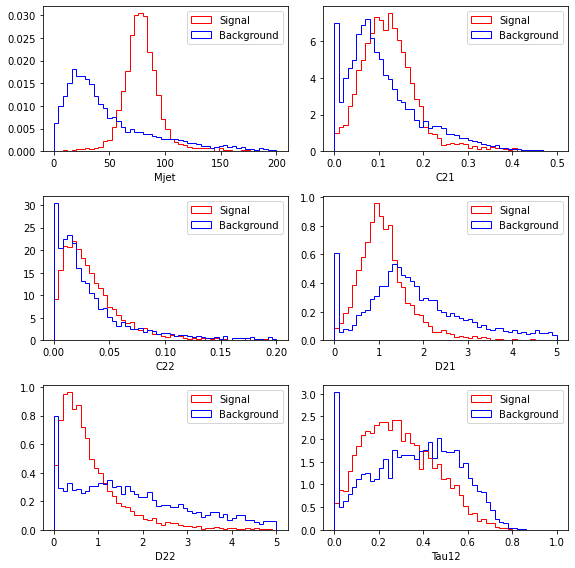

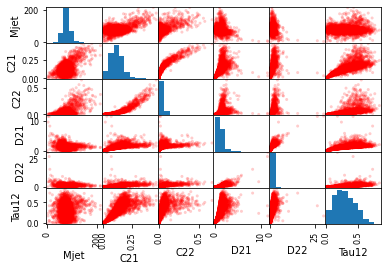

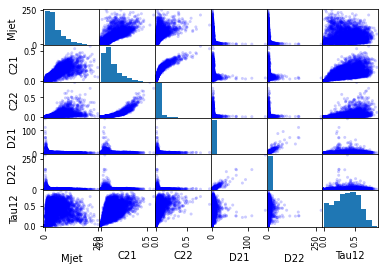

In [50]:
#@title Soluzione Parte 1
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

#importa il file .csv JetSubStruct.dat in un dataframe pandas
# nrows=10000 permette di leggere solo le prime 10k righe del file 
df = pd.read_csv('JetSubStruct.dat', nrows=10000)

#creo una lista con le feature (escludendo la label)
colonne = list(df.columns)
features = colonne[:-1]
print("colonne presenti nel pand dataframe:")
print(colonne)
print()

#printa il contenuto della tabella
print("Contenuto del dataframe pandas")
display(df)
print()

#statistica descrittiva delle colonne della tabella
print("Tabella con la statistica descrittiva")
display(df.describe())
print()
#matrice di correlazione (escludendo la colonna delle label)
print("Tabella con la correlazione tra le osservabili")
display(df[features].corr())
print()


#istogrammi delle osservabili

# seleziono gli eventi della classe con label 1
signal = df.loc[df['Label']>0.5]
# seleziono gli eventi della classe con label 0
background = df.loc[df['Label']<0.5]

# lista di range opportuni per gli istogrammi delle varie osservabili 
mrange = [[0,200],[0,0.5],[0,0.2],[0,5],[0,5],[0,1]]

print("Distribuzioni delle osservabili")
# questo comando permette di fissare le dimensioni della figura
plt.figure(figsize=(8,8))
for i in range(6):
  plt.subplot(3,2,i+1)
  plt.hist(signal[features[i]], bins=50, range=mrange[i], color='red', histtype='step', density=True, label='Signal')
  plt.xlabel(features[i])
  plt.hist(background[features[i]], bins=50, range=mrange[i], color='blue', histtype='step', density=True, label='Background')
  plt.xlabel(features[i])
  plt.legend()
plt.tight_layout()
print()

#scatter plots tra le osservabili

print("Scatter plot tra le osservabili")
_ = scatter_matrix(signal[features], color='red', alpha=0.2)
_ = scatter_matrix(background[features], color='blue', alpha=0.2)


**Parte 2:**

pre-processing delle feature

1.   splitting del campione in due sottocampioni: training e test (80%, 20%)


```
# suggerimento: usate lo slicing dei vettori che funziona anche su i dataframe di pandas

part_df = df[:1000].copy()  #crea un nuovo dataframe contenente le prime 1000 righe di df

#NOTA: le operazioni di slicing non resettano l'indice di colonna, per farlo:

part_df = part_df.reset_index(drop=True)

```


2.   normalizzare tutte le feature in modo che abbiano media zero e varianza 1

`SUGGERIMENTO: è possibile usare le funzioni *df.mean()* e *df.std()* di pandas e notare che quando applicate ad un dataframe sono applicate column-wise (cioè separatamente per ciascuna colonna)`

NOTA: i parametri per la normalizzazione delle feature vanno ottenuti con il solo campione di training in modo da evitare information leaks nel test set (il test set fa le veci di un campione mai osservato in precedenza, da utilizzare unicamente per la misura delle prestazioni finali del modello di ML addestrato, va quindi normalizzato rispetto ai parametri misurati dal solo training set)


In [ ]:
#code 

In [51]:
#@title Soluzione Parte 2

#divido in training e test sample

#size datasets
ntot = len(df.index)

#slicing
train = df[:int(ntot*0.8)].copy()
test = df[int(ntot*0.8):].copy()

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

#normalizzo solo rispetto al train set
train_mean = train[features].mean()
train_std  = train[features].std()
train[features] = (train[features]-train_mean)/train_std 
test[features] = (test[features]-train_mean)/train_std 

#controlliamo 

print ('Media osservabili training set dopo normalizzazione')
print(train[features].mean())
print()
print ('Deviazione standard osservabili training set dopo normalizzazione')
print(train[features].std())
print()

print ('Media osservabili test set dopo normalizzazione')
print(test[features].mean())
print()
print ('Deviazione standard osservabili test set dopo normalizzazione')
print(test[features].std())

Media osservabili training set dopo normalizzazione
Mjet    -4.061529e-15
C21      3.471626e-15
C22     -2.290654e-15
D21      9.291179e-16
D22      1.506004e-15
Tau12    2.842920e-15
dtype: float64

Deviazione standard osservabili training set dopo normalizzazione
Mjet     1.0
C21      1.0
C22      1.0
D21      1.0
D22      1.0
Tau12    1.0
dtype: float64

Media osservabili test set dopo normalizzazione
Mjet     0.023269
C21      0.050244
C22      0.044609
D21      0.046586
D22      0.018407
Tau12    0.036254
dtype: float64

Deviazione standard osservabili test set dopo normalizzazione
Mjet     0.996259
C21      1.028004
C22      1.112386
D21      1.564854
D22      1.300975
Tau12    0.990986
dtype: float64


**Parte 3:**

classificazione con Naive-Bayes, k-NN

1.   addestrare due modelli scikit-learn: uno di tipo *sklearn.naive_bayes NBGaussian*, e uno di tipo *neighbors.KNeighborsClassifier*, confrontare le prestazioni ottenute


```
# Guadare a come instanziare i differenti algoritmi sul sito di scikit-learn
# il pattern di utilizzo in scikit-learn di tutti i modelli di ML è sempre 
# lo stesso:
#
# modello = XXXXX( parametri ...) #creo un istanza del modello XXXXX
# modello.fit(features, labels)
# performance_metric = model.score(features, labels)
```


NOTA: per il modello KNeighborsClassifier testare 10 valori del parametro $k\in[1,30]$ e plottare l'accuracy vs $k$

In [ ]:
#code

In [52]:
#@title Soluzione 3A
#Naive Bays Classifier

from sklearn.naive_bayes import GaussianNB

#shuffle dei samples
np.random.seed(1234)
rndperm = np.random.permutation(train.shape[0])
rndperm2 = np.random.permutation(test.shape[0])

train_subset = train.loc[rndperm]
test_subset = test.loc[rndperm2]
train_subset = train_subset.reset_index(drop=True)
test_subset = test_subset.reset_index(drop=True)

model1 = GaussianNB()
model1.fit(train_subset[features].values, train_subset['Label'].values)

accuracy_train = model1.score(train_subset[features].values, train_subset['Label'].values)
accuracy_test = model1.score(test_subset[features].values, test_subset['Label'].values)

print('Naive Bays:')
print('Training accuracy: ', accuracy_train)
print('Test     accuracy: ', accuracy_test)

Naive Bays:
Training accuracy:  0.749
Test     accuracy:  0.75


k-NN:
k:  Training/Test accuracy: 
 1: 1.00     0.83
 4: 0.90     0.85
 7: 0.89     0.86
10: 0.89     0.87
13: 0.88     0.87
17: 0.88     0.88
20: 0.88     0.88
23: 0.88     0.87
26: 0.88     0.87
30: 0.88     0.87



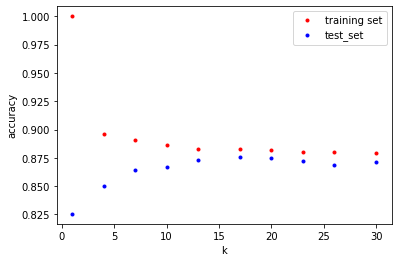

In [53]:
#@title Soluzione 3B
#k-NN Classifier
from sklearn import neighbors

print('k-NN:')
print('k:  Training/Test accuracy: ')
acc = []
acc_test = []
kval = []
for k in np.linspace(1,30,10, dtype=int):
  model2 = neighbors.KNeighborsClassifier(k)
  model2.fit(train[features].values, train['Label'].values)

  accuracy_train = model2.score(train[features].values, train['Label'].values)
  accuracy_test = model2.score(test[features].values, test['Label'].values)
  acc.append(accuracy_train)
  acc_test.append(accuracy_test)
  kval.append(k)
  print(f'{k:2d}: {accuracy_train:4.2f}     {accuracy_test:4.2f}')
print()

plt.plot(kval,acc, 'r.', label='training set')
plt.plot(kval,acc_test, 'b.', label='test_set')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.legend()


**Parte 4:**

Regressione con k-NN

1.   addestrare un modello scikit-learn di tipo n*eighbors.KNeighborsRegressor* per la task di predire il valore di Mjet a parire dalle altre 5 features (tau,C,D). Testare tre valori del parametro $k$:  $k=1,5,10, 20, 100$, e per oguno di essi printare il valore del coefficiente di determinazione $R^2$:

```
# coefficient of determination
# R^2 = 1 - SSres/SStot:  0 if a model perform as the baseline model, 1 for the best case, negative for worst than baseline
# SStot = residuals wrt data average (y-<y>)^2
# SSres = residuals wrt model prediction (y-pred)^2

#ottenibile tramite il metodo .score(...) applicato al  modello KNeighborsRegressor 
```

NOTA: esempio di uso come regressore di k-NN disponibile nel sito di scikit-learn: [link](https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html#sphx-glr-auto-examples-neighbors-plot-regression-py) 


2.   graficare i valori predetti per Mjet nel test set VS i valori veri

In [ ]:
#code

  1 R^2 score: 0.901
  5 R^2 score: 0.930
 10 R^2 score: 0.929
 20 R^2 score: 0.924
100 R^2 score: 0.878


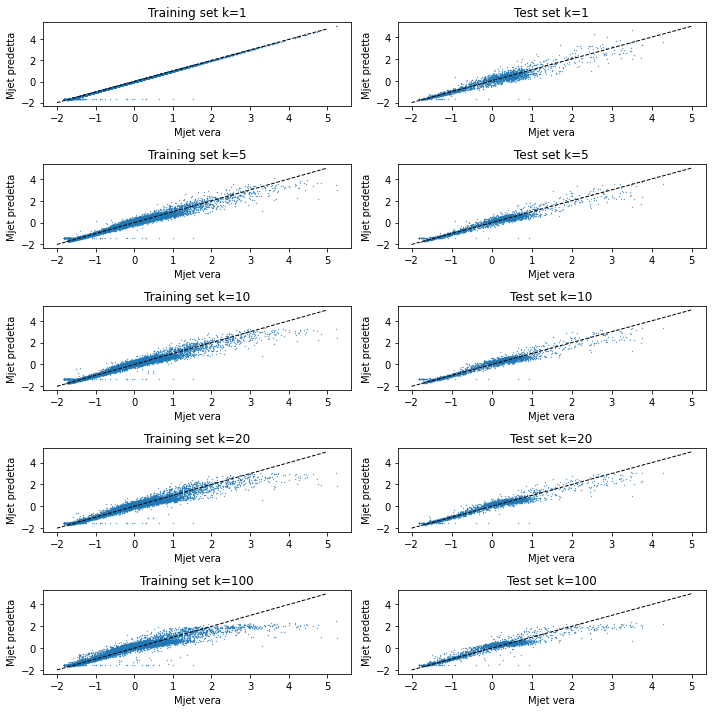

In [54]:
#@title Soluzione 4
#k-NN Regressor
from sklearn import neighbors

variabili = features[1:]
target = features[0] #il target è la prima feature 

plt.figure(figsize=(10,10))

for index,k in enumerate([1,5,10,20,100]):
  model3 = neighbors.KNeighborsRegressor(k)
  model3.fit(train[variabili].values, train[target].values)

  # coefficient of determination
  # R^2 = 1 - SSres/SStot:  0 if a model perform as the baseline model, 1 for the best case, negative for worst than baseline
  # SStot = residuals wrt data average (y-<y>)^2
  # SSres = residuals wrt model prediction (y-pred)^2
  print(f'{k:3d} R^2 score: {model3.score(test[variabili].values,test[target].values):.3f}')

  pred_train = model3.predict(train[variabili].values)
  pred_test =  model3.predict(test[variabili].values)

  plt.subplot(5,2,2*index+1)
  plt.title('Training set k='+str(k))
  plt.scatter(train[target].values,pred_train, s=0.1)
  plt.plot([-2,5],[-2,5], color='black', linewidth=1, linestyle='dashed')
  plt.ylabel('Mjet predetta')
  plt.xlabel('Mjet vera')

  plt.subplot(5,2,2*index+2)
  plt.title('Test set k='+str(k))
  plt.scatter(test[target].values, pred_test, s=0.1)
  plt.plot([-2,5],[-2,5], color='black', linewidth=1, linestyle='dashed')
  plt.ylabel('Mjet predetta')
  plt.xlabel('Mjet vera')

plt.tight_layout()

**Per casa:**

* provare a giocare con dimensione dei dataset, come scala il tempo di trainign del k-NN e del Naive-Bayes?
* ottimizzare $k$ nel training del classificatore k-NN, su cosa basereste la scelta ottimale? E nel caso del regressore?
* provate ad addestrare l'algoritmo di regressione eliminando alcune delle variabili, quali sono quelle più rilevanti? Perché?